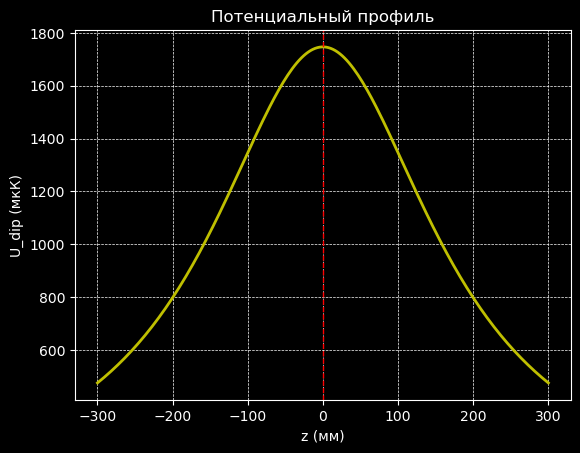

In [42]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Исходные параметры
s = 1231  # mm
W_0 = 243 * 10**(-3)  # mm
z_R = math.pi * (W_0**2) / (1012 * 10**(-6))  # mm
w_0 = 296 * 10**(12)  # Hz
delta = 88 * 10**(12)  # Hz
Gamma = 3 * 10**6  # Hz
f = 50  # mm
P = 2  # W

# Рассчитываем новые параметры
W_0_new = W_0 * (f / (((s - f)**2 + z_R**2) ** 0.5))  # mm

# Функция потенциала
def U_dip(r, z):
    W = W_0_new * np.sqrt(1 + (z / z_R)**2)
    I = (2 * P / (math.pi * (W * 10**(-3))**2)) * np.exp((-2 * r**2) / ((W * 10**(-3))**2))
    U = ((3 * math.pi * (3 * 10**8)**2) / (2 * w_0**3)) * Gamma * ((1 / delta) - (1 / (2 * w_0 + delta))) * I / ((2 * math.pi)**3)
    return U / (1.38 * 10**(-23) * 10**(-6))

# Диапазон для z
z = np.linspace(-300, 300, 200)
U_values = np.array([U_dip(0, zi) for zi in z])

# Построение графика
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.set_xlabel('z (мм)')
ax.set_ylabel('U_dip (мкК)')
ax.set_title('Потенциальный профиль')

ax.plot(z, U_values, color='y', lw=2)
ax.axvline(0, color='r', linestyle='--', lw=1)  # Вертикальная линия в нуле
ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output

# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
N_atom = 500000  # Число атомов
beam_radius = beam_diameter / 2  # Радиус пучка

def scattering_force(v, delta, I):
    """Сила рассеяния для доплеровского охлаждения."""
    s = I / I_s  # Нормированная интенсивность
    return hbar * k_L * s * Gamma / (2 * (1 + s + 4 * (delta - k_L * v)**2 / Gamma**2))

def simulate_mot(n_atoms=N_atom, time_max=1, dt=1e-5):
    """Моделирование движения атомов в МОЛ с расчётом температуры."""
    times = np.arange(0, time_max, dt)
    velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
    positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)  # Инициализация позиций в пределах пучка
    
    temperatures = []
    
    for i, t in enumerate(times):
        forces = scattering_force(velocities, 0, P_laser / (pi * (beam_diameter/2)**2))
        velocities += forces / mass_Rb * dt
        positions += velocities * dt
        
        # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
        trapped_atoms = np.abs(positions) < beam_radius
        trapped_positions = positions[trapped_atoms]
        trapped_velocities = velocities[trapped_atoms]
        
        # Средняя температура только для захваченных атомов
        if len(trapped_velocities) > 0:
            T_avg_trapped = np.mean(mass_Rb * trapped_velocities**2) / k
        else:
            T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0
        
        temperatures.append(T_avg_trapped)

        # Вывод процента завершения моделирования
        if i % (len(times) // 1000) == 0:  # каждые 10% моделирования
            clear_output()
            print(f"Прогресс: {100 * i / len(times):.1f}%")

    min_temp = np.min(temperatures)  # Минимальная температура

    return positions, velocities, times, temperatures, min_temp, temp_stability

def plot_results(positions, velocities, times, temperatures, min_temp):
    """Графики распределений и температуры."""
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    ax[0].hist(positions * 1e3, bins=50, density=True, alpha=0.7, color='b')
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность")
    
    ax[1].hist(velocities, bins=50, density=True, alpha=0.7, color='r')
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")
    
    ax[2].plot(times * 1e6, temperatures, color='g')
    ax[2].set_xlabel("Время (μs)")
    ax[2].set_ylabel("Средняя температура (K)")
    ax[2].set_title(f"Зависимость температуры от времени для захваченных атомов\n"
                    f"Мин. температура: {min_temp:.2f} K")
    
    plt.tight_layout()
    plt.show()

# Запуск моделирования
positions, velocities, times, temperatures, min_temp, temp_stability = simulate_mot()
plot_results(positions, velocities, times, temperatures, min_temp)

# Вывод минимальной температуры и стабильности
print(f"Минимальная температура: {min_temp:.2f} K")
print(f"Процент стабильности температуры: {temp_stability:.2f}%")

Прогресс: 1.2%


KeyboardInterrupt: 

Прогресс: моделирование 3/3, 99.9%


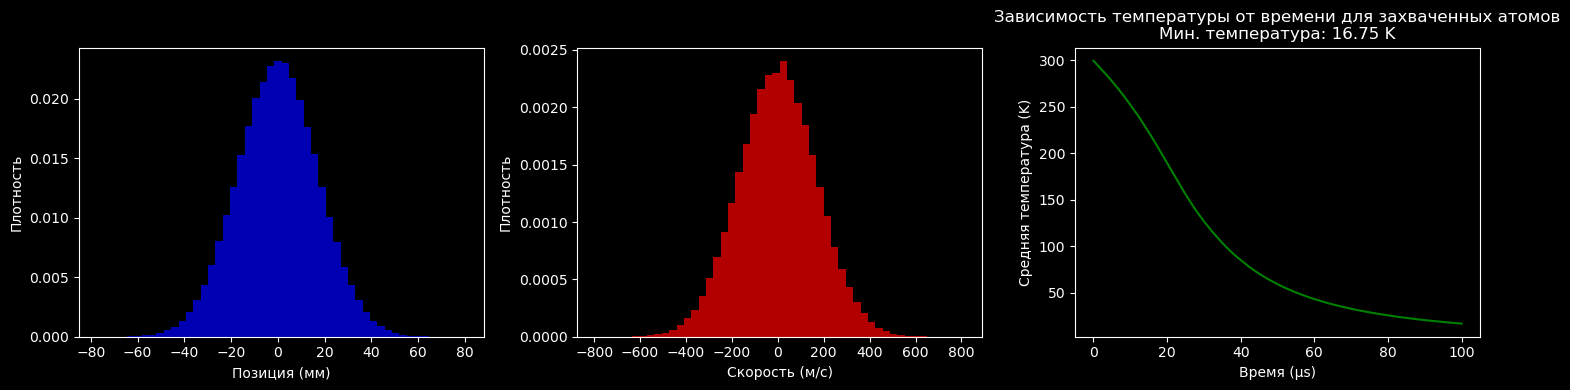

Минимальная температура: 16.75 K


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output

# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
N_atom = 500000  # Число атомов
beam_radius = beam_diameter / 2  # Радиус пучка

# Флуктуации в параметрах
wavelength_fluctuation = 0.001  # процент флуктуации длины волны
power_fluctuation = 0.05  # 5% флуктуации мощности
magnetic_fluctuation = 0.05  # 5% флуктуации магнитного поля

def scattering_force(v, delta, I, delta_wavelength=0, delta_magnetic=0):
    """Сила рассеяния для доплеровского охлаждения с флуктуациями в длине волны, мощности и магнитном поле."""
    # Флуктуации длины волны
    k_L_eff = 2 * pi / (wavelength * (1 + np.random.normal(0, delta_wavelength)))  # изменяем волновой вектор
    s = I / I_s  # Нормированная интенсивность
    delta_effective = delta * (1 + np.random.normal(0, delta_magnetic))  # Флуктуации магнитного поля
    return hbar * k_L_eff * s * Gamma / (2 * (1 + s + 4 * (delta_effective - k_L_eff * v)**2 / Gamma**2))

def simulate_mot(n_atoms=N_atom, time_max=1e-4, dt=1e-7, n_simulations=3):
    """Моделирование движения атомов в МОЛ с расчётом температуры, с учётом флуктуаций."""
    temperatures_all = []

    for _ in range(n_simulations):  # многократное моделирование для усреднения
        times = np.arange(0, time_max, dt)
        velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
        positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)  # Инициализация позиций в пределах пучка

        temperatures = []

        for i, t in enumerate(times):
            # Влияние флуктуаций на интенсивность
            P_laser_eff = P_laser * (1 + np.random.normal(0, power_fluctuation))  # флуктуации мощности
            forces = scattering_force(velocities, 0, P_laser_eff / (pi * (beam_diameter / 2)**2), 
                                      delta_wavelength=wavelength_fluctuation, delta_magnetic=magnetic_fluctuation)
            velocities += forces / mass_Rb * dt
            positions += velocities * dt

            # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
            trapped_atoms = np.abs(positions) < beam_radius
            trapped_positions = positions[trapped_atoms]
            trapped_velocities = velocities[trapped_atoms]

            # Средняя температура только для захваченных атомов
            if len(trapped_velocities) > 0:
                T_avg_trapped = np.mean(mass_Rb * trapped_velocities**2) / k
            else:
                T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0

            temperatures.append(T_avg_trapped)

            # Вывод процента завершения моделирования
            clear_output()
            if i % (len(times) // 1000) == 0:  # каждые 0.1% моделирования
                print(f"Прогресс: моделирование {_+1}/{n_simulations}, {100 * i / len(times):.1f}%")

        temperatures_all.append(temperatures)

    # Усреднение температур за несколько симуляций
    avg_temperatures = np.mean(temperatures_all, axis=0)
    min_temp = np.min(avg_temperatures)  # Минимальная температура

    clear_output()
    print(f"Прогресс: 100%, моделирование завершено")

    return positions, velocities, times, avg_temperatures, min_temp

def plot_results(positions, velocities, times, temperatures, min_temp):
    """Графики распределений и температуры."""
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    ax[0].hist(positions * 1e3, bins=50, density=True, alpha=0.7, color='b')
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность")
    
    ax[1].hist(velocities, bins=50, density=True, alpha=0.7, color='r')
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")
    
    ax[2].plot(times * 1e6, temperatures, color='g')
    ax[2].set_xlabel("Время (μs)")
    ax[2].set_ylabel("Средняя температура (K)")
    ax[2].set_title(f"Зависимость температуры от времени для захваченных атомов\n"
                    f"Мин. температура: {min_temp:.2f} K")
    
    plt.tight_layout()
    plt.show()

# Запуск моделирования
positions, velocities, times, temperatures, min_temp = simulate_mot()
plot_results(positions, velocities, times, temperatures, min_temp)

# Вывод минимальной температуры
print(f"Минимальная температура: {min_temp:.2f} K")

Прогресс: 100%, моделирование завершено


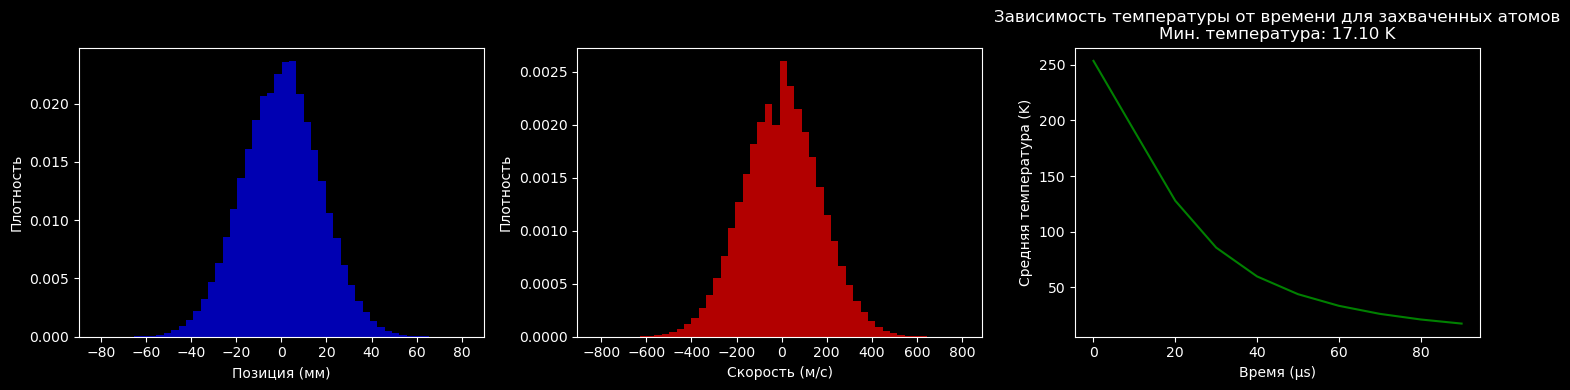

Минимальная температура: 17.10 K


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output

# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
N_atom = 500000  # Число атомов
beam_radius = beam_diameter / 2  # Радиус пучка

# Флуктуации в параметрах
wavelength_fluctuation = 0.001  # процент флуктуации длины волны
power_fluctuation = 0.05  # 5% флуктуации мощности
magnetic_fluctuation = 0.05  # 5% флуктуации магнитного поля

def scattering_force(v, delta, I, r, delta_wavelength=0, delta_magnetic=0):
    """Сила рассеяния для доплеровского охлаждения с флуктуациями в длине волны, мощности и магнитном поле."""
    # Флуктуации длины волны
    k_L_eff = 2 * pi / (wavelength * (1 + np.random.normal(0, delta_wavelength)))  # изменяем волновой вектор
    s = I / I_s  # Нормированная интенсивность
    delta_effective = delta * (1 + np.random.normal(0, delta_magnetic))  # Флуктуации магнитного поля

    # Интенсивность в зависимости от радиуса r для гауссового пучка
    I_r = I * np.exp(-r**2 / beam_radius**2)

    return hbar * k_L_eff * I_r * Gamma / (2 * (1 + s + 4 * (delta_effective - k_L_eff * v)**2 / Gamma**2))

def simulate_mot(n_atoms=N_atom, time_max=1e-4, dt=1e-5, n_simulations=2):
    """Моделирование движения атомов в МОЛ с расчётом температуры, с учётом флуктуаций."""
    temperatures_all = []

    for _ in range(n_simulations):  # многократное моделирование для усреднения
        times = np.arange(0, time_max, dt)
        velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
        positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)  # Инициализация позиций в пределах пучка

        temperatures = []

        for i, t in enumerate(times):
            # Влияние флуктуаций на интенсивность
            P_laser_eff = P_laser * (1 + np.random.normal(0, power_fluctuation))  # флуктуации мощности
            forces = np.array([scattering_force(v, 0, P_laser_eff / (pi * (beam_diameter / 2)**2), pos, 
                                              delta_wavelength=wavelength_fluctuation, delta_magnetic=magnetic_fluctuation)
                               for v, pos in zip(velocities, positions)])
            velocities += forces / mass_Rb * dt
            positions += velocities * dt

            # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
            trapped_atoms = np.abs(positions) < beam_radius
            trapped_positions = positions[trapped_atoms]
            trapped_velocities = velocities[trapped_atoms]

            # Средняя температура только для захваченных атомов
            if len(trapped_velocities) > 0:
                T_avg_trapped = np.mean(mass_Rb * trapped_velocities**2) / k
            else:
                T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0

            temperatures.append(T_avg_trapped)

            # Вывод процента завершения моделирования
            clear_output()
            if len(times) > 1000 and i % (len(times) // 1000) == 0:  # каждые 0.1% моделирования
                print(f"Прогресс: моделирование {_+1}/{n_simulations}, {100 * i / len(times):.1f}%")

        temperatures_all.append(temperatures)

    # Усреднение температур за несколько симуляций
    avg_temperatures = np.mean(temperatures_all, axis=0)
    min_temp = np.min(avg_temperatures)  # Минимальная температура

    clear_output()
    print(f"Прогресс: 100%, моделирование завершено")

    return positions, velocities, times, avg_temperatures, min_temp

def plot_results(positions, velocities, times, temperatures, min_temp):
    """Графики распределений и температуры."""
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    ax[0].hist(positions * 1e3, bins=50, density=True, alpha=0.7, color='b')
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность")
    
    ax[1].hist(velocities, bins=50, density=True, alpha=0.7, color='r')
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")
    
    ax[2].plot(times * 1e6, temperatures, color='g')
    ax[2].set_xlabel("Время (μs)")
    ax[2].set_ylabel("Средняя температура (K)")
    ax[2].set_title(f"Зависимость температуры от времени для захваченных атомов\n"
                    f"Мин. температура: {min_temp:.2f} K")
    
    plt.tight_layout()
    plt.show()

# Запуск моделирования
positions, velocities, times, temperatures, min_temp = simulate_mot()
plot_results(positions, velocities, times, temperatures, min_temp)

# Вывод минимальной температуры
print(f"Минимальная температура: {min_temp:.2f} K")

Прогресс: 100%, моделирование завершено


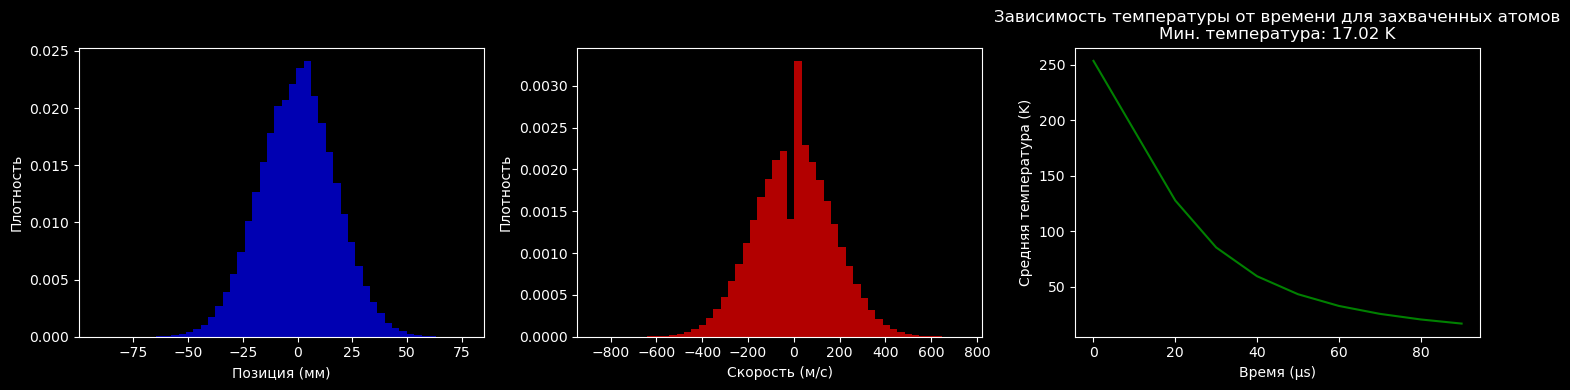

Минимальная температура: 17.02 K
Критическая мощность репампера: 1.30e-03 Вт


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output

# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
N_atom = 500000  # Число атомов
beam_radius = beam_diameter / 2  # Радиус пучка

# Флуктуации в параметрах
wavelength_fluctuation = 0.001  # процент флуктуации длины волны
power_fluctuation = 0.05  # 5% флуктуации мощности
magnetic_fluctuation = 0.05  # 5% флуктуации магнитного поля

def scattering_force(v, delta, I, r, delta_wavelength=0, delta_magnetic=0):
    """Сила рассеяния для доплеровского охлаждения с флуктуациями в длине волны, мощности и магнитном поле."""
    # Флуктуации длины волны
    k_L_eff = 2 * pi / (wavelength * (1 + np.random.normal(0, delta_wavelength)))  # изменяем волновой вектор
    s = I / I_s  # Нормированная интенсивность
    delta_effective = delta * (1 + np.random.normal(0, delta_magnetic))  # Флуктуации магнитного поля

    # Интенсивность в зависимости от радиуса r для гауссового пучка
    I_r = I * np.exp(-r**2 / beam_radius**2)

    return hbar * k_L_eff * I_r * Gamma / (2 * (1 + s + 4 * (delta_effective - k_L_eff * v)**2 / Gamma**2))

def critical_laser_power():
    """Определяет критическую мощность лазера, при которой все атомы теряют возбуждение."""
    # Критическая интенсивность для перехода на высокий энергетический уровень
    I_critical = I_s  # Примерная критическая интенсивность (можно дополнительно вычислить для конкретных атомных уровней)
    
    # Для критической мощности (при заданном диаметре пучка)
    P_critical = I_critical * pi * beam_radius**2
    return P_critical

def simulate_mot(n_atoms=N_atom, time_max=1e-4, dt=1e-5, n_simulations=2):
    """Моделирование движения атомов в МОЛ с расчётом температуры, с учётом флуктуаций."""
    temperatures_all = []

    for _ in range(n_simulations):  # многократное моделирование для усреднения
        times = np.arange(0, time_max, dt)
        velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
        positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)  # Инициализация позиций в пределах пучка

        temperatures = []

        for i, t in enumerate(times):
            # Влияние флуктуаций на интенсивность
            P_laser_eff = P_laser * (1 + np.random.normal(0, power_fluctuation))  # флуктуации мощности
            forces = np.array([scattering_force(v, 0, P_laser_eff / (pi * (beam_diameter / 2)**2), pos, 
                                              delta_wavelength=wavelength_fluctuation, delta_magnetic=magnetic_fluctuation)
                               for v, pos in zip(velocities, positions)])
            velocities += forces / mass_Rb * dt
            positions += velocities * dt

            # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
            trapped_atoms = np.abs(positions) < beam_radius
            trapped_positions = positions[trapped_atoms]
            trapped_velocities = velocities[trapped_atoms]

            # Средняя температура только для захваченных атомов
            if len(trapped_velocities) > 0:
                T_avg_trapped = np.mean(mass_Rb * trapped_velocities**2) / k
            else:
                T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0

            temperatures.append(T_avg_trapped)

            # Вывод процента завершения моделирования
            clear_output()
            if len(times) > 1000 and i % (len(times) // 1000) == 0:  # каждые 0.1% моделирования
                print(f"Прогресс: моделирование {_+1}/{n_simulations}, {100 * i / len(times):.1f}%")

        temperatures_all.append(temperatures)

    # Усреднение температур за несколько симуляций
    avg_temperatures = np.mean(temperatures_all, axis=0)
    min_temp = np.min(avg_temperatures)  # Минимальная температура

    clear_output()
    print(f"Прогресс: 100%, моделирование завершено")

    return positions, velocities, times, avg_temperatures, min_temp

def plot_results(positions, velocities, times, temperatures, min_temp):
    """Графики распределений и температуры."""
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    ax[0].hist(positions * 1e3, bins=50, density=True, alpha=0.7, color='b')
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность")
    
    ax[1].hist(velocities, bins=50, density=True, alpha=0.7, color='r')
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")
    
    ax[2].plot(times * 1e6, temperatures, color='g')
    ax[2].set_xlabel("Время (μs)")
    ax[2].set_ylabel("Средняя температура (K)")
    ax[2].set_title(f"Зависимость температуры от времени для захваченных атомов\n"
                    f"Мин. температура: {min_temp:.2f} K")
    
    plt.tight_layout()
    plt.show()

# Запуск моделирования
positions, velocities, times, temperatures, min_temp = simulate_mot()
plot_results(positions, velocities, times, temperatures, min_temp)

# Вывод минимальной температуры и критической мощности
P_critical = critical_laser_power()
print(f"Минимальная температура: {min_temp:.2f} K")
print(f"Критическая мощность репампера: {P_critical:.2e} Вт")

Прогресс: 100%, моделирование завершено


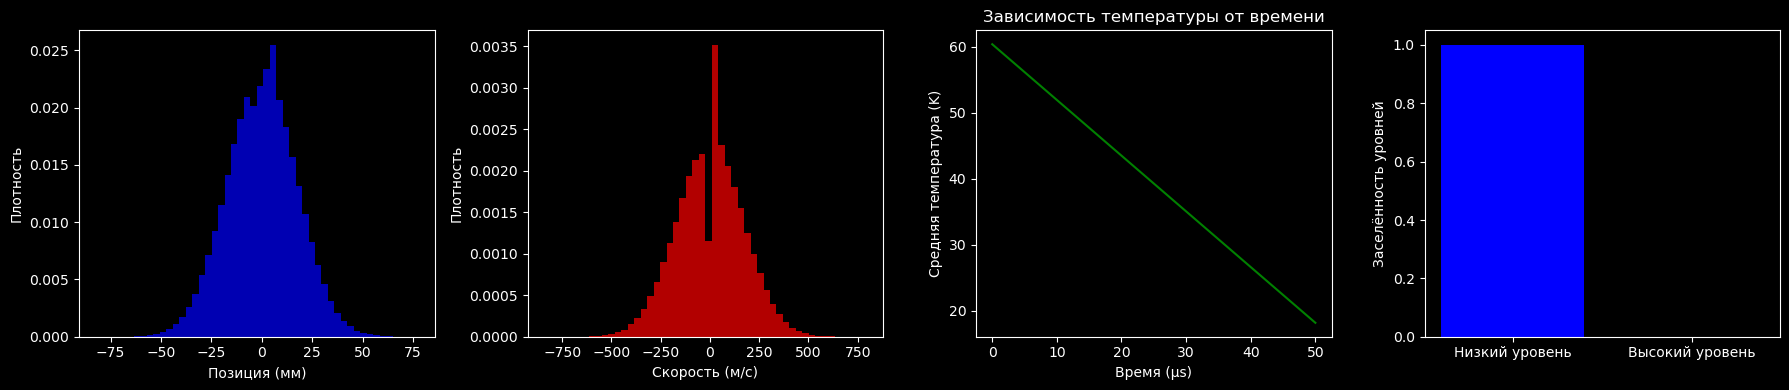

Критическая мощность репампера: 1.30e-03 Вт


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output

# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
N_atom = 500000  # Число атомов
beam_radius = beam_diameter / 2  # Радиус пучка

# Флуктуации в параметрах
wavelength_fluctuation = 0.001  # процент флуктуации длины волны
power_fluctuation = 0.05  # 5% флуктуации мощности
magnetic_fluctuation = 0.05  # 5% флуктуации магнитного поля

# Параметры репампера (интенсивность, частота)
repumper_intensity = 1e-3  # интенсивность репампера в Вт
repumper_wavelength = 780.5e-9  # длина волны репампера
repumper_effect = 0.1  # коэффициент влияния репампера на переходы

def scattering_force(v, delta, I, r, delta_wavelength=0, delta_magnetic=0):
    """Сила рассеяния для доплеровского охлаждения с флуктуациями в длине волны, мощности и магнитном поле."""
    # Флуктуации длины волны
    k_L_eff = 2 * pi / (wavelength * (1 + np.random.normal(0, delta_wavelength)))  # изменяем волновой вектор
    s = I / I_s  # Нормированная интенсивность
    delta_effective = delta * (1 + np.random.normal(0, delta_magnetic))  # Флуктуации магнитного поля

    # Интенсивность в зависимости от радиуса r для гауссового пучка
    I_r = I * np.exp(-r**2 / beam_radius**2)

    return hbar * k_L_eff * I_r * Gamma / (2 * (1 + s + 4 * (delta_effective - k_L_eff * v)**2 / Gamma**2))

def repumper_effect_on_levels(velocities, I_repumper, delta_wavelength=0):
    """Репампер влияет на переходы между уровнями атома."""
    k_L_eff_repumper = 2 * pi / (repumper_wavelength * (1 + np.random.normal(0, delta_wavelength)))
    # Определяем, какой процент атомов изменит свой уровень
    level_transition_prob = repumper_effect * I_repumper / I_s * np.exp(-velocities**2 / (2 * k * T0 / mass_Rb))
    return level_transition_prob

def critical_laser_power():
    """Определяет критическую мощность лазера, при которой все атомы теряют возбуждение."""
    # Критическая интенсивность для перехода на высокий энергетический уровень
    I_critical = I_s  # Примерная критическая интенсивность (можно дополнительно вычислить для конкретных атомных уровней)
    
    # Для критической мощности (при заданном диаметре пучка)
    P_critical = I_critical * pi * beam_radius**2
    return P_critical

def simulate_mot(n_atoms=N_atom, time_max=1e-4, dt=5e-5, n_simulations=1):
    """Моделирование движения атомов в МОЛ с расчётом температуры, с учётом флуктуаций и репампера."""
    temperatures_all = []
    level_populations_all = []
    velocity_distributions_all = []

    for _ in range(n_simulations):  # многократное моделирование для усреднения
        times = np.arange(0, time_max, dt)
        velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
        positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)  # Инициализация позиций в пределах пучка

        temperatures = []
        level_populations = np.zeros(2)  # Два уровня: низкий и высокий
        velocity_distributions = []

        for i, t in enumerate(times):
            # Влияние флуктуаций на интенсивность
            P_laser_eff = P_laser * (1 + np.random.normal(0, power_fluctuation))  # флуктуации мощности
            forces = np.array([scattering_force(v, 0, P_laser_eff / (pi * (beam_diameter / 2)**2), pos, 
                                              delta_wavelength=wavelength_fluctuation, delta_magnetic=magnetic_fluctuation)
                               for v, pos in zip(velocities, positions)])
            velocities += forces / mass_Rb * dt
            positions += velocities * dt

            # Переходы между уровнями из-за репампера
            level_transitions = repumper_effect_on_levels(velocities, repumper_intensity)
            level_populations[0] = np.mean(1 - level_transitions)  # доля атомов на низком уровне
            level_populations[1] = np.mean(level_transitions)      # доля атомов на высоком уровне

            # Распределение скоростей для каждого уровня
            velocity_distributions.append([np.mean(velocities[level_transitions == 0]),
                                          np.mean(velocities[level_transitions == 1])])

            # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
            trapped_atoms = np.abs(positions) < beam_radius
            trapped_positions = positions[trapped_atoms]
            trapped_velocities = velocities[trapped_atoms]

            # Средняя температура только для захваченных атомов
            if len(trapped_velocities) > 0:
                T_avg_trapped = np.mean(mass_Rb * trapped_velocities**2) / k
            else:
                T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0

            temperatures.append(T_avg_trapped)

            # Вывод процента завершения моделирования
            clear_output()
            if len(times) > 1000 and i % (len(times) // 1000) == 0:  # каждые 0.1% моделирования
                print(f"Прогресс: моделирование {_+1}/{n_simulations}, {100 * i / len(times):.1f}%")

        temperatures_all.append(temperatures)
        level_populations_all.append(level_populations)
        velocity_distributions_all.append(velocity_distributions)

    # Усреднение температур и заселённости уровней за несколько симуляций
    avg_temperatures = np.mean(temperatures_all, axis=0)
    avg_level_populations = np.mean(level_populations_all, axis=0)
    avg_velocity_distributions = np.mean(velocity_distributions_all, axis=0)

    clear_output()
    print(f"Прогресс: 100%, моделирование завершено")

    return positions, velocities, times, avg_temperatures, avg_level_populations, avg_velocity_distributions

def plot_results(positions, velocities, times, temperatures, avg_level_populations, avg_velocity_distributions):
    """Графики распределений и температуры."""
    fig, ax = plt.subplots(1, 4, figsize=(18, 4))

    ax[0].hist(positions * 1e3, bins=50, density=True, alpha=0.7, color='b')
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность")

    ax[1].hist(velocities, bins=50, density=True, alpha=0.7, color='r')
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")

    ax[2].plot(times * 1e6, temperatures, color='g')
    ax[2].set_xlabel("Время (μs)")
    ax[2].set_ylabel("Средняя температура (K)")
    ax[2].set_title(f"Зависимость температуры от времени")

    ax[3].bar([0, 1], avg_level_populations, color=['blue', 'red'])
    ax[3].set_xticks([0, 1])
    ax[3].set_xticklabels(["Низкий уровень", "Высокий уровень"])
    ax[3].set_ylabel("Заселённость уровней")

    plt.tight_layout()
    plt.show()

# Запуск моделирования
positions, velocities, times, temperatures, avg_level_populations, avg_velocity_distributions = simulate_mot()
plot_results(positions, velocities, times, temperatures, avg_level_populations, avg_velocity_distributions)

# Вывод критической мощности
P_critical = critical_laser_power()
print(f"Критическая мощность репампера: {P_critical:.2e} Вт")

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output
import time





# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
beam_radius = beam_diameter / 2  # Радиус пучка

# Флуктуации в параметрах
wavelength_fluctuation = 0.001  # процент флуктуации длины волны
power_fluctuation = 0.01  # % флуктуации мощности
magnetic_fluctuation = 0.05  # % флуктуации магнитного поля

# Параметры репампера (интенсивность, частота)
repumper_intensity = 1e-5  # интенсивность репампера в Вт
repumper_wavelength = 780.5e-9  # длина волны репампера
repumper_effect = 0.1  # коэффициент влияния репампера на переходы

# Параметры симуляции
atoms_quantity = 500000  # Число атомов
nsim = 10 # Количество симуляций
timesim=10**(-5) # Период симуляции
dtsim=3*(10**(-9)) # Шаг симуляции (в секундах)

# Параметры переходов между уровнями (примерные значения)
transition_probabilities = {
    (0, 1): 1e-5,  # Переход с уровня 0 (F=1) на уровень 1 (F=2)
    (1, 2): 1e-5,  # Переход с уровня 1 (F=2) на уровень 2 (F=3)
    (2, 3): 1e-5,  # Переход с уровня 2 (F=3) на уровень 3 (темновой)
    (1, 0): 1e-5,  # Переход с уровня 1 (F=2) на уровень 0 (F=1)
    (2, 1): 1e-5,  # Переход с уровня 2 (F=3) на уровень 1 (F=2)
    (3, 2): 1e-5,  # Переход с уровня 3 (темновой) на уровень 2 (F=3)
}






def transition_between_levels(levels, temperature, dt):
    """
    Функция для обработки переходов между уровнями в процессе работы ловушки.
    Это простая модель с вероятностными переходами между уровнями атомов.

    levels - массив уровней атомов
    temperature - температура ловушки (средняя кинетическая энергия)
    dt - временной шаг
    """
    for i in range(len(levels)):
        # Для каждого атома с вероятностью по температуре и переходам между уровнями
        for (start, end), prob in transition_probabilities.items():
            # Вычисляем вероятность перехода на основе температуры
            transition_prob = prob * np.exp(-abs(start - end) * temperature / k) * dt
            if np.random.rand() < transition_prob:
                if levels[i] == start:
                    levels[i] = end  # Переход на новый уровень
    return levels

def repumper_effect_on_levels(levels, velocities, I_repumper, temperature, delta_wavelength=0):
    """
    Воздействие репампера: переводит атомы с F=1 на F=2, а также может учитывать возможные утечки на темновый уровень F=4.
    
    levels - массив уровней атомов (0 - F=1, 1 - F=2, 2 - F=3, 3 - F=4)
    velocities - массив скоростей атомов
    I_repumper - интенсивность репампирующего лазера
    delta_wavelength - флуктуации длины волны (по умолчанию 0)
    
    Возвращает массив новых уровней атомов после воздействия репампера.
    """
    # Волновой вектор репампирующего лазера с учётом флуктуаций
    k_L_eff_repumper = 2 * np.pi / (repumper_wavelength * (1 + np.random.normal(0, delta_wavelength)))

    # Вероятность перехода с F=1 на F=2 (основной эффект репампера)
    transition_prob = repumper_effect * I_repumper / I_s * np.exp(-velocities**2 / (2 * k * temperature / mass_Rb))

    # Создаём копию массива уровней
    level_transition_prob = np.copy(levels)

    # Только атомы на уровне F=1 могут перейти на F=2
    mask_F1 = levels == 0  # индексы атомов на уровне F=1
    transitions = np.random.rand(len(levels)) < transition_prob  # случайные события перехода
    level_transition_prob[mask_F1 & transitions] = 1  # Переход F=1 -> F=2

    # Дополнительные спонтанные утечки с F=2 и F=3 на F=4 (полностью темновый уровень)
    leak_prob = 0.01  # Маленькая вероятность утечки на темновый уровень (параметр можно подстраивать)
    mask_F2_F3 = (levels == 1) | (levels == 2)  # Атомы на F=2 и F=3
    leaks = np.random.rand(len(levels)) < leak_prob  # случайные утечки
    level_transition_prob[mask_F2_F3 & leaks] = 3  # Переход F=2,3 -> F=4

    return level_transition_prob

def scattering_force(v, delta, I, r, delta_wavelength=0, delta_magnetic=0):
    """Сила рассеяния для доплеровского охлаждения с флуктуациями в длине волны, мощности и магнитном поле."""
    # Флуктуации длины волны
    k_L_eff = 2 * pi / (wavelength * (1 + np.random.normal(0, delta_wavelength)))  # изменяем волновой вектор
    s = I / I_s  # Нормированная интенсивность
    delta_effective = delta * (1 + np.random.normal(0, delta_magnetic))  # Флуктуации магнитного поля

    # Интенсивность в зависимости от радиуса r для гауссового пучка
    I_r = I * np.exp(-r**2 / beam_radius**2)

    return hbar * k_L_eff * I_r * Gamma / (2 * (1 + s + 4 * (delta_effective - k_L_eff * v)**2 / Gamma**2))




def simulate_mot(n_atoms=atoms_quantity, time_max=timesim, dt=dtsim, n_simulations=nsim):
    """Моделирование движения атомов в МОЛ с расчётом температуры, временем жизни и репампером."""
    positions_all = []
    velocities_all = []
    temperatures_all = []
    velocity_distributions_all = []
    level_populations_all = []

    for _ in range(n_simulations):  # многократное моделирование для усреднения
        times = np.arange(0, time_max, dt)
        velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
        positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)  # Инициализация позиций в пределах пучка
        levels = np.random.choice([0, 1, 2, 3], size=n_atoms, p=[0.5, 0.35, 0.15, 0])  # 40% F=1, 30% F=2, 30% F=3
        T_avg_trapped = T0
        velocities_to_avg = []
        positions_to_avg = []
        temperatures = []
        velocity_distributions = []
        levels_distributions = []

        start_time = time.time()

        for i, t in enumerate(times):
            
            # Моделирование динамики с учётом влияния флуктуаций
            P_laser_eff = P_laser * (1 + np.random.normal(0, power_fluctuation))  # флуктуации мощности
            forces = np.array([scattering_force(v, 0, P_laser_eff / (pi * (beam_diameter / 2)**2), pos, 
                                              delta_wavelength=wavelength_fluctuation, delta_magnetic=magnetic_fluctuation)
                               for v, pos in zip(velocities, positions)])
            velocities += forces / mass_Rb * dt
            positions += velocities * dt
            velocities_to_avg.append(velocities)
            positions_to_avg.append(positions)

            # Распределение скоростей для каждого уровня
            # Вычисление средних значений скорости для уровней
            if np.any(levels == 1):
                avg_level_1_velocity = np.nanmean(np.where(levels == 1, velocities, np.nan))
            else:
                avg_level_1_velocity = np.nan
            
            if np.any(levels == 2):
                avg_level_2_velocity = np.nanmean(np.where(levels == 2, velocities, np.nan))
            else:
                avg_level_2_velocity = np.nan
            
            if np.any(levels == 3):
                avg_level_3_velocity = np.nanmean(np.where(levels == 3, velocities, np.nan))
            else:
                avg_level_3_velocity = np.nan
            
            if np.any(levels == 4):
                avg_level_4_velocity = np.nanmean(np.where(levels == 4, velocities, np.nan))
            else:
                avg_level_4_velocity = np.nan
            
            # Добавляем результаты в список
            velocity_distributions.append([
                avg_level_1_velocity,
                avg_level_2_velocity,
                avg_level_3_velocity,
                avg_level_4_velocity
            ])

            # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
            trapped_atoms = np.abs(positions) < beam_radius
            trapped_positions = positions[trapped_atoms]
            trapped_velocities = velocities[trapped_atoms]

            # Средняя температура только для захваченных атомов
            if len(trapped_velocities) > 0:
                T_avg_trapped = np.mean(mass_Rb * trapped_velocities**2) / k
            else:
                T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0

            temperatures.append(T_avg_trapped)

            # Переходы между уровнями из-за репампера
            temperature = T_avg_trapped
            levels_ = repumper_effect_on_levels(levels, velocities, repumper_intensity, temperature)
            levels = levels_

            # Переходы между уровнями в процессе работы МОЛ
            levels_ = transition_between_levels(levels, temperature, dt)
            levels = levels_

            # Заселённость уровней (распределение)
            level_counts = np.bincount(levels, minlength=4)
            level_distribution = level_counts / np.sum(level_counts)
            levels_distributions.append(level_distribution)

            # Оценка прогресса с учётом времени
            clear_output(wait=True)
            if len(times) > 1000 and i % (len(times) // 1000) == 0:  # каждые 0.1% моделирования
                elapsed_time = time.time() - start_time  # прошедшее время
                time_per_iteration = elapsed_time / (i + 1)  # время на одну итерацию
                time_remaining = time_per_iteration * (len(times) - i) + time_per_iteration * (n_simulations - 1 - _)  # оставшееся время
                print(f"Прогресс: симуляция {_+1}/{n_simulations}, актуальная симуляция завершена на {100 * i / len(times):.1f}%, "
                      f"Примерное время до полного завершения моделирования: {time.strftime('%H:%M:%S', time.gmtime(time_remaining))}")

        velocities_all.append(velocities_to_avg)
        positions_all.append(positions_to_avg)
        temperatures_all.append(temperatures)
        level_populations_all.append(levels_distributions)
        velocity_distributions_all.append(velocity_distributions)

    # Усреднение температур и заселённости уровней за несколько симуляций
    avg_positions = np.mean(positions_all, axis=tuple(range(n_simulations)))
    avg_velocities = np.mean(velocities_all, axis=tuple(range(n_simulations)))
    avg_temperatures = np.mean(temperatures_all, axis=0)
    avg_level_populations = np.mean(level_populations_all, axis=0)
    avg_velocity_distributions = np.mean(velocity_distributions_all, axis=0)

    clear_output()
    print(f"Прогресс: 100%, моделирование завершено")

    return times, avg_positions, avg_velocities, avg_temperatures, avg_level_populations, avg_velocity_distributions




def plot_results(times, positions, velocities, temperatures, avg_level_populations, avg_velocity_distributions):
    """Графики распределений, температуры и времени жизни ловушки."""
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))

    # Позиции атомов на разных временных моментах
    ax[0].hist(positions[0] * 1e3, bins=50, density=True, alpha=0.7, color='r', label="0%")
    ax[0].hist(positions[len(positions) // 5] * 1e3, bins=50, density=True, alpha=0.7, color='orange', label="20%")
    ax[0].hist(positions[len(positions) // 2] * 1e3, bins=50, density=True, alpha=0.7, color='y', label="50%")
    ax[0].hist(positions[len(positions) * 4 // 5] * 1e3, bins=50, density=True, alpha=0.7, color='g', label="80%")
    ax[0].hist(positions[len(positions) - 1] * 1e3, bins=50, density=True, alpha=0.7, color='b', label="100%")
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность вероятности")
    ax[0].set_title(f"Положение атомов в моменты 0%, 20%, 50%, 80%, 100% периода моделирования")
    ax[0].legend()

    # Скорости атомов на разных временных моментах
    ax[1].hist(velocities[0], bins=50, density=True, alpha=0.7, color='r', label="0%")
    ax[1].hist(velocities[len(velocities) // 5], bins=50, density=True, alpha=0.7, color='orange', label="20%")
    ax[1].hist(velocities[len(velocities) // 2], bins=50, density=True, alpha=0.7, color='y', label="50%")
    ax[1].hist(velocities[len(velocities) * 4 // 5], bins=50, density=True, alpha=0.7, color='g', label="80%")
    ax[1].hist(velocities[len(velocities) - 1], bins=50, density=True, alpha=0.7, color='b', label="100%")
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")
    ax[1].set_title(f"Динамика атомов в моменты 0%, 20%, 50%, 80%, 100% периода моделирования")
    ax[1].legend()

    fig, ax = plt.subplots(1, 1, figsize=(22, 6))
    
    # Температура в зависимости от времени
    ax.plot(times * 1e6, temperatures, color='g')
    ax.set_xlabel("Время (μs)")
    ax.set_ylabel("Средняя температура (K)")
    ax.set_title("Зависимость средней температуры захваченных в МОЛ атомов от времени")
    
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    
    # Заселённости уровней
    level_1_population, level_2_population, level_3_population, level_4_population = avg_level_populations
    ax[0].plot(times, level_1_population, 'g-', label="Уровень 1")
    ax[0].plot(times, level_2_population, 'b-', label="Уровень 2")
    ax[0].plot(times, level_3_population, 'r-', label="Уровень 3")
    ax[0].set_xlabel('Время')
    ax[0].set_ylabel('Заселённость уровней')
    ax[0].set_title('Заселённости уровней в зависимости от времени')
    ax[0].legend()

    # Динамика атомов по уровням
    level_1_velocities, level_2_velocities, level_3_velocities, level_4_velocities = avg_velocity_distributions.T
    ax[1].plot(times, level_1_velocities, 'g-', label="Уровень 1")
    ax[1].plot(times, level_2_velocities, 'b-', label="Уровень 2")
    ax[1].plot(times, level_3_velocities, 'r-', label="Уровень 3")
    ax[1].set_xlabel('Время')
    ax[1].set_ylabel('Средняя скорость (м/с)')
    ax[1].set_title('Динамика атомов по уровням в зависимости от времени')
    ax[1].legend()

    plt.show()

    # Распределение скоростей для каждого уровня
    fig_velocities, ax_velocities = plt.subplots(1, 3, figsize=(22, 6))
    
    for i, level_velocities in enumerate([level_1_velocities, level_2_velocities, level_3_velocities]):
        for j, time_point in enumerate([0, len(times) // 5, len(times) // 2, 4 * len(times) // 5, len(times) - 1]):
            # Фильтрация NaN значений
            clean_velocities = level_velocities[time_point]
            clean_velocities = clean_velocities[~np.isnan(clean_velocities)]  # удаляем NaN значения
            
            # Строим гистограмму только с чистыми данными
            ax_velocities[i].hist(clean_velocities, bins=50, density=True, alpha=0.7, label=f"{j*20}%", color=['r', 'orange', 'y', 'g', 'b'][j])
    
        ax_velocities[i].set_xlabel("Скорость (м/с)")
        ax_velocities[i].set_ylabel("Плотность")
        ax_velocities[i].set_title(f"Распределение скоростей для Уровня {i + 1}")
        ax_velocities[i].legend()
    
    plt.show()



# Запуск моделирования
times, positions, velocities, temperatures, avg_level_populations, avg_velocity_distributions = simulate_mot()
plot_results(times, positions, velocities, temperatures, avg_level_populations, avg_velocity_distributions)

KeyboardInterrupt: 

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, c, hbar, pi
from IPython.display import clear_output
import time
import numba
import cupy as cp




# Физические параметры
mass_Rb = 87 * 1.66e-27  # кг, масса атома Rb-87
wavelength = 780.2e-9  # м, длина волны охлаждающего лазера
k_L = 2 * pi / wavelength  # волновой вектор
Gamma = 2 * pi * 6.07e6  # Гц, естественная ширина перехода
P_laser = 8e-3 / 6  # Вт, мощность одного пучка
beam_diameter = 10e-3  # м, диаметр пучка
I_s = 16.5  # Вт/м^2, насыщенность перехода
T0 = 300.00  # К, начальная температура атомов
v_threshold = 1e-2  # Порог скорости для захваченных атомов (м/с)
beam_radius = beam_diameter / 2  # Радиус пучка

# Флуктуации в параметрах
wavelength_fluctuation = 0.001  # процент флуктуации длины волны
power_fluctuation = 0.01  # % флуктуации мощности
magnetic_fluctuation = 0.05  # % флуктуации магнитного поля

# Параметры репампера (интенсивность, частота)
repumper_intensity = 1e-5  # интенсивность репампера в Вт
repumper_wavelength = 780.5e-9  # длина волны репампера
repumper_effect = 0.1  # коэффициент влияния репампера на переходы

# Параметры симуляции
atoms_quantity = 500000  # Число атомов
nsim = 10 # Количество симуляций
timesim = 10**(-5) # Период симуляции
dtsim = 3 * 10**(-9) # Шаг симуляции (в секундах)

# Параметры переходов между уровнями (примерные значения)
transition_probabilities = {
    (0, 1): 1e-5,  # Переход с уровня 0 (F=1) на уровень 1 (F=2)
    (1, 2): 1e-5,  # Переход с уровня 1 (F=2) на уровень 2 (F=3)
    (2, 3): 1e-5,  # Переход с уровня 2 (F=3) на уровень 3 (темновой)
    (1, 0): 1e-5,  # Переход с уровня 1 (F=2) на уровень 0 (F=1)
    (2, 1): 1e-5,  # Переход с уровня 2 (F=3) на уровень 1 (F=2)
    (3, 2): 1e-5,  # Переход с уровня 3 (темновой) на уровень 2 (F=3)
}




@numba.jit(nopython=True, parallel=True)
def transition_between_levels(levels, temperature, dt):
    """
    Параллельная версия обработки переходов между уровнями с использованием Numba.
    """
    for i in numba.prange(len(levels)):  # Параллельная обработка с использованием prange
        for (start, end), prob in transition_probabilities.items():
            transition_prob = prob * np.exp(-abs(start - end) * temperature / k) * dt
            if np.random.rand() < transition_prob:
                if levels[i] == start:
                    levels[i] = end  # Переход на новый уровень
    return levels

@numba.jit(nopython=True, parallel=True)
def repumper_effect_on_levels(levels, velocities, I_repumper, temperature, delta_wavelength=0):
    """
    Параллельная версия воздействия репампера на уровни с использованием Numba.
    """
    k_L_eff_repumper = 2 * np.pi / (repumper_wavelength * (1 + np.random.normal(0, delta_wavelength)))
    transition_prob = repumper_effect * I_repumper / I_s * np.exp(-velocities**2 / (2 * k * temperature / mass_Rb))
    level_transition_prob = np.copy(levels)

    mask_F1 = levels == 0
    transitions = np.random.rand(len(levels)) < transition_prob
    level_transition_prob[mask_F1 & transitions] = 1

    leak_prob = 0.01
    mask_F2_F3 = (levels == 1) | (levels == 2)
    leaks = np.random.rand(len(levels)) < leak_prob
    level_transition_prob[mask_F2_F3 & leaks] = 3

    return level_transition_prob

@numba.jit(nopython=True, parallel=True)
def scattering_force(v, delta, I, r, delta_wavelength=0, delta_magnetic=0):
    """
    Сила рассеяния с учётом флуктуаций с использованием Numba для параллельных вычислений.
    """
    k_L_eff = 2 * pi / (wavelength * (1 + np.random.normal(0, delta_wavelength)))
    s = I / I_s
    delta_effective = delta * (1 + np.random.normal(0, delta_magnetic))
    I_r = I * np.exp(-r**2 / beam_radius**2)

    return hbar * k_L_eff * I_r * Gamma / (2 * (1 + s + 4 * (delta_effective - k_L_eff * v)**2 / Gamma**2))





def simulate_mot(n_atoms=atoms_quantity, time_max=timesim, dt=dtsim, n_simulations=nsim):
    """Моделирование движения атомов в МОЛ с расчётом температуры, временем жизни и репампером."""
    positions_all = []
    velocities_all = []
    temperatures_all = []
    velocity_distributions_all = []
    level_populations_all = []

    for _ in range(n_simulations):  # многократное моделирование для усреднения
        times = np.arange(0, time_max, dt)
        
        # Инициализация на numpy (для совместимости с остальными частями кода)
        velocities = np.random.normal(0, np.sqrt(k * T0 / mass_Rb), n_atoms)
        positions = np.random.uniform(-beam_radius, beam_radius, n_atoms)
        levels = np.random.choice([0, 1, 2, 3], size=n_atoms, p=[0.5, 0.35, 0.15, 0])  # 40% F=1, 30% F=2, 30% F=3
        T_avg_trapped = T0
        velocities_to_avg = []
        positions_to_avg = []
        temperatures = []
        velocity_distributions = []
        levels_distributions = []

        start_time = time.time()

        # Переводим данные на cupy для использования на GPU
        velocities_cp = cp.array(velocities)
        positions_cp = cp.array(positions)
        levels_cp = cp.array(levels)

        for i, t in enumerate(times):
            # Моделирование динамики с учётом флуктуаций
            P_laser_eff = P_laser * (1 + np.random.normal(0, power_fluctuation))  # флуктуации мощности
            forces = cp.array([scattering_force(v, 0, P_laser_eff / (np.pi * (beam_diameter / 2)**2), pos, 
                                   delta_wavelength=wavelength_fluctuation, delta_magnetic=magnetic_fluctuation)
                               for v, pos in zip(velocities_cp, positions_cp)])

            velocities_cp += forces / mass_Rb * dt
            positions_cp += velocities_cp * dt
            velocities_to_avg.append(cp.asnumpy(velocities_cp))
            positions_to_avg.append(cp.asnumpy(positions_cp))

            # Распределение скоростей для каждого уровня
            velocity_distributions.append([
                cp.asnumpy(np.nanmean(cp.where(levels_cp == 1, velocities_cp, np.nan))),
                cp.asnumpy(np.nanmean(cp.where(levels_cp == 2, velocities_cp, np.nan))),
                cp.asnumpy(np.nanmean(cp.where(levels_cp == 3, velocities_cp, np.nan))),
                cp.asnumpy(np.nanmean(cp.where(levels_cp == 4, velocities_cp, np.nan)))
            ])

            # Отбор только захваченных атомов, которые находятся внутри пучка (в пределах радиуса)
            trapped_atoms = cp.abs(positions_cp) < beam_radius
            trapped_positions = positions_cp[trapped_atoms]
            trapped_velocities = velocities_cp[trapped_atoms]

            # Средняя температура только для захваченных атомов
            if len(trapped_velocities) > 0:
                T_avg_trapped = cp.mean(mass_Rb * trapped_velocities**2) / k
            else:
                T_avg_trapped = 0  # Если нет захваченных атомов, температура равна 0

            temperatures.append(cp.asnumpy(T_avg_trapped))

            # Переходы между уровнями из-за репампера
            levels_cp = repumper_effect_on_levels(levels_cp, velocities_cp, repumper_intensity, T_avg_trapped)

            # Переходы между уровнями в процессе работы МОЛ
            levels_cp = transition_between_levels(levels_cp, T_avg_trapped, dt)

            # Заселённость уровней (распределение)
            level_counts = cp.bincount(levels_cp, minlength=4)
            level_distribution = level_counts / cp.sum(level_counts)
            levels_distributions.append(cp.asnumpy(level_distribution))

            # Оценка прогресса с учётом времени
            clear_output(wait=True)
            if len(times) > 1000 and i % (len(times) // 1000) == 0:  # каждые 0.1% моделирования
                elapsed_time = time.time() - start_time  # прошедшее время
                time_per_iteration = elapsed_time / (i + 1)  # время на одну итерацию
                time_remaining = time_per_iteration * (len(times) - i) + time_per_iteration * (n_simulations - 1 - _)  # оставшееся время
                print(f"Прогресс: симуляция {_+1}/{n_simulations}, актуальная симуляция завершена на {100 * i / len(times):.1f}%, "
                      f"Примерное время до полного завершения моделирования: {time.strftime('%H:%M:%S', time.gmtime(time_remaining))}")

        velocities_all.append(velocities_to_avg)
        positions_all.append(positions_to_avg)
        temperatures_all.append(temperatures)
        level_populations_all.append(levels_distributions)
        velocity_distributions_all.append(velocity_distributions)

    # Усреднение температур и заселённости уровней за несколько симуляций
    avg_positions = np.mean(positions_all, axis=tuple(range(n_simulations)))
    avg_velocities = np.mean(velocities_all, axis=tuple(range(n_simulations)))
    avg_temperatures = np.mean(temperatures_all, axis=0)
    avg_level_populations = np.mean(level_populations_all, axis=0)
    avg_velocity_distributions = np.mean(velocity_distributions_all, axis=0)

    clear_output()
    print(f"Прогресс: 100%, моделирование завершено")

    return times, avg_positions, avg_velocities, avg_temperatures, avg_level_populations, avg_velocity_distributions








def plot_results(times, positions, velocities, temperatures, avg_level_populations, avg_velocity_distributions):
    """Графики распределений, температуры и времени жизни ловушки."""
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))

    # Позиции атомов на разных временных моментах
    ax[0].hist(positions[0] * 1e3, bins=50, density=True, alpha=0.7, color='r', label="0%")
    ax[0].hist(positions[len(positions) // 5] * 1e3, bins=50, density=True, alpha=0.7, color='orange', label="20%")
    ax[0].hist(positions[len(positions) // 2] * 1e3, bins=50, density=True, alpha=0.7, color='y', label="50%")
    ax[0].hist(positions[len(positions) * 4 // 5] * 1e3, bins=50, density=True, alpha=0.7, color='g', label="80%")
    ax[0].hist(positions[len(positions) - 1] * 1e3, bins=50, density=True, alpha=0.7, color='b', label="100%")
    ax[0].set_xlabel("Позиция (мм)")
    ax[0].set_ylabel("Плотность вероятности")
    ax[0].set_title(f"Положение атомов в моменты 0%, 20%, 50%, 80%, 100% периода моделирования")
    ax[0].legend()

    # Скорости атомов на разных временных моментах
    ax[1].hist(velocities[0], bins=50, density=True, alpha=0.7, color='r', label="0%")
    ax[1].hist(velocities[len(velocities) // 5], bins=50, density=True, alpha=0.7, color='orange', label="20%")
    ax[1].hist(velocities[len(velocities) // 2], bins=50, density=True, alpha=0.7, color='y', label="50%")
    ax[1].hist(velocities[len(velocities) * 4 // 5], bins=50, density=True, alpha=0.7, color='g', label="80%")
    ax[1].hist(velocities[len(velocities) - 1], bins=50, density=True, alpha=0.7, color='b', label="100%")
    ax[1].set_xlabel("Скорость (м/с)")
    ax[1].set_ylabel("Плотность")
    ax[1].set_title(f"Динамика атомов в моменты 0%, 20%, 50%, 80%, 100% периода моделирования")
    ax[1].legend()

    fig, ax = plt.subplots(1, 1, figsize=(22, 6))
    
    # Температура в зависимости от времени
    ax.plot(times * 1e6, temperatures, color='g')
    ax.set_xlabel("Время (μs)")
    ax.set_ylabel("Средняя температура (K)")
    ax.set_title("Зависимость средней температуры захваченных в МОЛ атомов от времени")
    
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    
    # Заселённости уровней
    level_1_population, level_2_population, level_3_population, level_4_population = avg_level_populations
    ax[0].plot(times, level_1_population, 'g-', label="Уровень 1")
    ax[0].plot(times, level_2_population, 'b-', label="Уровень 2")
    ax[0].plot(times, level_3_population, 'r-', label="Уровень 3")
    ax[0].set_xlabel('Время')
    ax[0].set_ylabel('Заселённость уровней')
    ax[0].set_title('Заселённости уровней в зависимости от времени')
    ax[0].legend()

    # Динамика атомов по уровням
    level_1_velocities, level_2_velocities, level_3_velocities, level_4_velocities = avg_velocity_distributions.T
    ax[1].plot(times, level_1_velocities, 'g-', label="Уровень 1")
    ax[1].plot(times, level_2_velocities, 'b-', label="Уровень 2")
    ax[1].plot(times, level_3_velocities, 'r-', label="Уровень 3")
    ax[1].set_xlabel('Время')
    ax[1].set_ylabel('Средняя скорость (м/с)')
    ax[1].set_title('Динамика атомов по уровням в зависимости от времени')
    ax[1].legend()

    plt.show()

    # Распределение скоростей для каждого уровня
    fig_velocities, ax_velocities = plt.subplots(1, 3, figsize=(22, 6))
    
    for i, level_velocities in enumerate([level_1_velocities, level_2_velocities, level_3_velocities]):
        for j, time_point in enumerate([0, len(times) // 5, len(times) // 2, 4 * len(times) // 5, len(times) - 1]):
            # Фильтрация NaN значений
            clean_velocities = level_velocities[time_point]
            clean_velocities = clean_velocities[~np.isnan(clean_velocities)]  # удаляем NaN значения
            
            # Строим гистограмму только с чистыми данными
            ax_velocities[i].hist(clean_velocities, bins=50, density=True, alpha=0.7, label=f"{j*20}%", color=['r', 'orange', 'y', 'g', 'b'][j])
    
        ax_velocities[i].set_xlabel("Скорость (м/с)")
        ax_velocities[i].set_ylabel("Плотность")
        ax_velocities[i].set_title(f"Распределение скоростей для Уровня {i + 1}")
        ax_velocities[i].legend()
    
    plt.show()



# Запуск моделирования
times, positions, velocities, temperatures, avg_level_populations, avg_velocity_distributions = simulate_mot()
plot_results(times, positions, velocities, temperatures, avg_level_populations, avg_velocity_distributions)

ModuleNotFoundError: No module named 'cupy'